#Twitter Sentiment Analysis using Sentiment140 dataset

In [1]:
#Installing transformers library

!pip install transformers --quiet

     |████████████████████████████████| 1.9MB 7.9MB/s 
     |████████████████████████████████| 3.2MB 38.5MB/s 
     |████████████████████████████████| 890kB 41.8MB/s 


In [2]:
# Importing required modules

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
# Configuration

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [4]:
# Reading the dataset

project_path = '/content/drive/MyDrive/Cryptofuture/'
train_data_path = os.path.join(project_path, 'traindata.csv')

df = pd.read_csv(train_data_path, encoding='latin')

df.sample(10)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"
379611,0,2052381070,Sat Jun 06 00:32:23 PDT 2009,NO_QUERY,Portablemonkey,Tried to purchase a parked domain through GoDa...
1189017,4,1983449090,Sun May 31 13:10:36 PDT 2009,NO_QUERY,jessig06,on lunch....dj should come eat with me
667030,0,2245480599,Fri Jun 19 16:11:34 PDT 2009,NO_QUERY,Aligrl,Just got back from VA Tech Equine Medical Cent...
93541,0,1770706008,Mon May 11 22:01:35 PDT 2009,NO_QUERY,leyyyy,can't log in to my other twitter account. supe...
1365937,4,2050057894,Fri Jun 05 17:59:34 PDT 2009,NO_QUERY,AmiAhuja,@TamaraSchilling Adventure - That's what we al...


In [5]:
# Adding columns to the dataframe

df.columns = ['targets', 'id', 'date', 'flag', 'user', 'tweets']

df.sample(5)

,targets,id,date,flag,user,tweets
33408,0,1564500376,Mon Apr 20 03:47:11 PDT 2009,NO_QUERY,cheloneill,when the weathers so fab why do we have to wor...
1041124,4,1957039926,Thu May 28 23:21:01 PDT 2009,NO_QUERY,matthewdean,@shayboogs hahah I know Shay And i luv the h...
832491,4,1557601864,Sun Apr 19 05:03:52 PDT 2009,NO_QUERY,sdsportschick,Headed out for an early morning hike!
948959,4,1823599100,Sat May 16 22:25:02 PDT 2009,NO_QUERY,jojovela,@ItsJustDi apparently the party is at your hou...
1562416,4,2186814798,Mon Jun 15 19:22:35 PDT 2009,NO_QUERY,jobrofan16,is with @jonasbrosfan1 going to buy LVATT tog...


In [6]:
# 0 - negative and 4 - positive
# Normalizing in range 0-1

def to_sentiment(target):
    if target == 4:
        return 1
    else:
        return 0

In [7]:
df.targets = df.targets.apply(to_sentiment)
df.sample(10)

,targets,id,date,flag,user,tweets
985984,1,1834526042,Mon May 18 03:16:11 PDT 2009,NO_QUERY,sankesolutions,"@brianteeman Thats not far from here, oh well ..."
737168,0,2265178205,Sun Jun 21 05:58:55 PDT 2009,NO_QUERY,JShastt,Birthday is over but Happy Fathers Day!
1599434,1,2193450988,Tue Jun 16 08:28:35 PDT 2009,NO_QUERY,GGGKeri,@xomollydollyxo Exactly!
1566586,1,2187816613,Mon Jun 15 20:51:03 PDT 2009,NO_QUERY,rachellock22,I love when theres an update as soon as i wake...
920270,1,1753956450,Sun May 10 04:18:27 PDT 2009,NO_QUERY,Sophie_Julia,@DomHarvey meannn party hahaha always a good ...
668558,0,2245971448,Fri Jun 19 16:54:32 PDT 2009,NO_QUERY,biiapassos,"Alright, i did almost everything. Just didn't ..."
1266673,1,1999690223,Mon Jun 01 20:39:13 PDT 2009,NO_QUERY,judez_xo,@_most_wanted_ lol silly boy! I love you
1056511,1,1962515452,Fri May 29 11:09:53 PDT 2009,NO_QUERY,metroretrovtg,@pdxfabricdeli I see ya PDX! And receiving yo...
1119067,1,1973708572,Sat May 30 11:40:42 PDT 2009,NO_QUERY,analiviacoelho,Enjoying a sweeet saturday at the winery
662820,0,2243867553,Fri Jun 19 14:00:17 PDT 2009,NO_QUERY,djdsf,"@merlinglx It was odd, never happened to me be..."


In [8]:
# Removing the url tweets and replacing @ and #

import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
  text = hashtags.sub(' hashtag', text)
  text = mentions.sub(' entity', text)
  return text.strip().lower()
  
def match_expr(pattern, string):
  return not pattern.search(string) == None

def data_without_urls(dataset):
    link_with_urls = dataset.tweets.apply(lambda x: match_expr(urls, x))
    return dataset[[not e for e in link_with_urls]]

In [9]:
df.tweets = df.tweets.apply(process_text)

df.sample(10)

,targets,id,date,flag,user,tweets
155953,0,1955987916,Thu May 28 20:58:48 PDT 2009,NO_QUERY,bball_joe,"entity suspense, suspense. what to do during t..."
65470,0,1691011481,Sun May 03 16:53:35 PDT 2009,NO_QUERY,jima6636,"entity yes but for like th 10,000 time it is n..."
340579,0,2014869572,Wed Jun 03 02:57:31 PDT 2009,NO_QUERY,ahmednuaman,entity just visited your web site: the intro b...
1464968,1,2064294954,Sun Jun 07 05:51:19 PDT 2009,NO_QUERY,vickeeeee,skyping with the rents!! hashtag
1016218,1,1881671536,Fri May 22 05:16:37 PDT 2009,NO_QUERY,YvetteObeney,"entity the hashtag is great, picked up &amp; f..."
305376,0,1999976626,Mon Jun 01 21:10:19 PDT 2009,NO_QUERY,jenry1523,drats! i miscalculated.
1379356,1,2052118737,Fri Jun 05 23:43:05 PDT 2009,NO_QUERY,jemihawkx33,chatting with entity
233101,0,1979306124,Sun May 31 02:29:01 PDT 2009,NO_QUERY,_We_ArE_bRoKeN_,no ones up at 4 30 its summer people!!!
1039976,1,1956886953,Thu May 28 22:56:51 PDT 2009,NO_QUERY,wahliaodotcom,hashtag love to entity ... and i hope u are al...
139114,0,1880728269,Fri May 22 02:17:11 PDT 2009,NO_QUERY,andrewbeaton,i just lost the game


In [10]:
# Removing url tweets

df = data_without_urls(df)
df.shape

(1529862, 6)

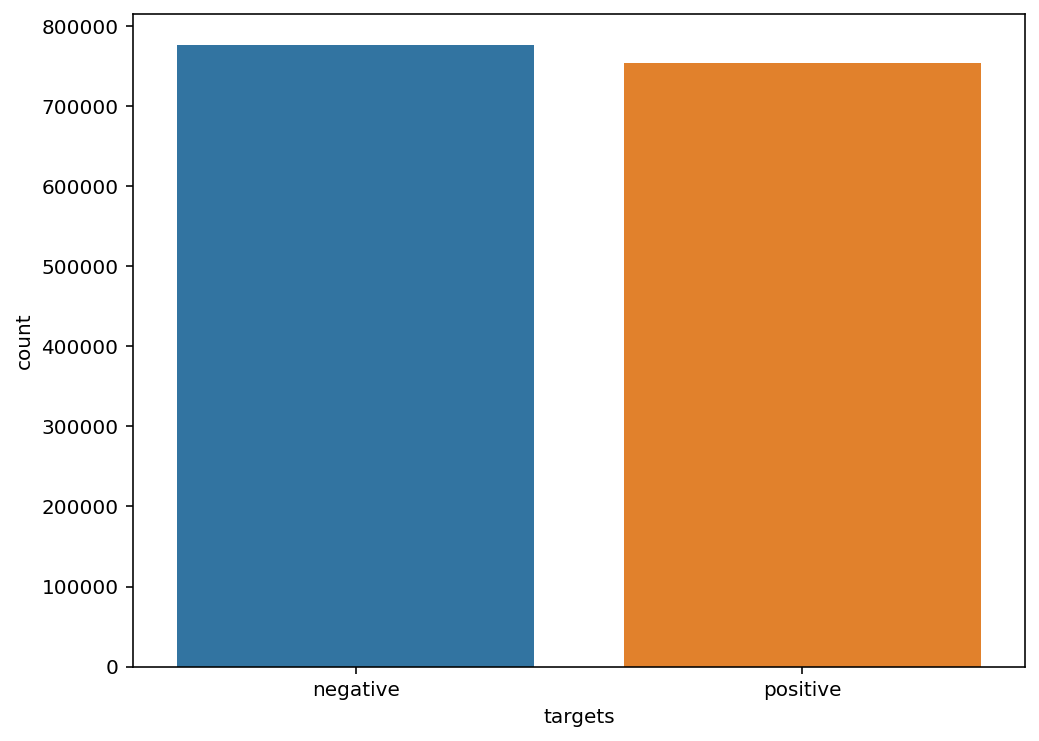

In [11]:
# Checking inbalance

CLASS_NAMES = ['negative', 'positive']

ax = sns.countplot(x=df.targets)
ax.set_xticklabels(CLASS_NAMES)
plt.savefig(os.path.join(project_path, 'count_plot.jpg'))

In [12]:
# Dropping unnecessary columns

df = df.drop(['id', 'date', 'flag', 'user'], axis=1)
df.head()

,targets,tweets
0,0,is upset that he can't update his facebook by ...
1,0,entity i dived many times for the ball. manage...
2,0,my whole body feels itchy and like its on fire
3,0,"entity no, it's not behaving at all. i'm mad. ..."
4,0,entity not the whole crew


In [13]:
# Saving the cleaned dataset

df.to_csv(os.path.join(project_path, 'traindata_cleaned.csv'), index=False)

##Tokenization

In [14]:
df = pd.read_csv(os.path.join(project_path, 'traindata_cleaned.csv'))

df.sample(10)

,targets,tweets
68320,0,"still listening to loveline, sure does have lo..."
583642,0,entity don't tease me. i don't rarely get sbs
618941,0,i feel sick this is not a good way to start s...
1318499,1,"entity it was the craziest illness. oh well, g..."
1215531,1,entity if your into the whole taking a picture...
1130937,1,entity ok following you now
755242,0,ugh it's way too late... i have to get up early
449515,0,i kinda wish i hadn't read the sookie stackhou...
566924,0,entity oh no! sorry to hear about your vacay d...
1068933,1,entity yolaaaa. entity lmao. she's already fa...


In [15]:
# Tokenizer

PRETRAINED_MODEL_NAME = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [16]:
# Finding the maximum token length

from tqdm import tqdm

token_lens = []

for t in tqdm(df.tweets):
    tokens = tokenizer.encode(t, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 1529862/1529862 [09:34<00:00, 2660.70it/s]


In [17]:
# Saving the token_lens list for further use

import pickle

with open(os.path.join(project_path, 'token_lens.txt'), 'wb') as file:
    pickle.dump(token_lens, file)

# Reading the list

# with open(os.path.join(project_path, 'token_lens.txt'), 'rb') as file:
#     token_lens = pickle.load(file)
# token_lens

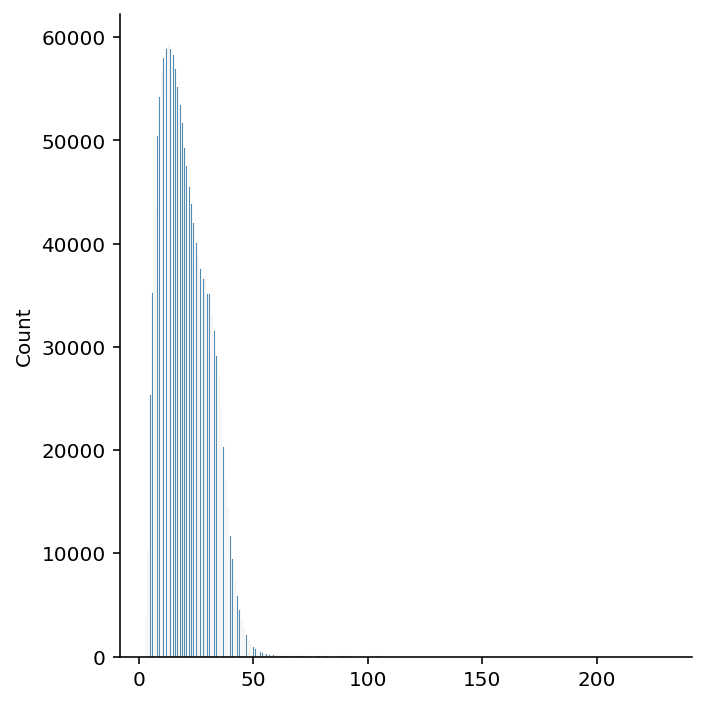

In [18]:
# Plot

ax = sns.displot(token_lens)
plt.savefig(os.path.join(project_path, 'token_lens.jpg'))

In [19]:
# From the plot the suitable maximum length = 240

MAX_LEN = 240

##Creating dataset

In [20]:
class TweetSentimentDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweet = self.tweets[item]
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweet': tweet,
            'targets': torch.tensor(target, dtype=torch.long),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [21]:
# Creating training testing and validation data

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [22]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(1376875, 2)
(76494, 2)
(76493, 2)


In [23]:
# Defining dataloader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetSentimentDataset(
        tweets=df.tweets.to_numpy(),
        targets=df.targets.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [24]:
# Creating train, val and test dataloader

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [25]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet', 'targets', 'input_ids', 'attention_mask'])

##Bert model

In [26]:
# Bert Model

bert_model = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)

In [27]:
# Creating Sentiment classifier class

class TweetSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(TweetSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        o = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooler_output = o['pooler_output']
        output = self.drop(pooler_output)
        return self.out(output)

In [28]:
# Creating a model instance
CLASS_NAMES = ['negative', 'positive']

model = TweetSentimentClassifier(len(CLASS_NAMES))
model = model.to(device)

In [29]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 240])
torch.Size([16, 240])


In [30]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5980, 0.4020],
        [0.4509, 0.5491],
        [0.5663, 0.4337],
        [0.6108, 0.3892],
        [0.4906, 0.5094],
        [0.5987, 0.4013],
        [0.5801, 0.4199],
        [0.6074, 0.3926],
        [0.7234, 0.2766],
        [0.5325, 0.4675],
        [0.5093, 0.4907],
        [0.6720, 0.3280],
        [0.4819, 0.5181],
        [0.7000, 0.3000],
        [0.5861, 0.4139],
        [0.7146, 0.2854]], device='cuda:0', grad_fn=<SoftmaxBackward>)

##Training

In [31]:
# Defining epochs, optimizer, scheduler, loss_fn

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [32]:
# Training model function

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
# Evaluating model function

def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
